### **Support Services**

**Authored by**: Thakoor Madhuvaishali

**Level:** Intermediate

**Pre-requisite Skills:** Python, Data analysis, data cleaning, data visualisation,

Scenario:

As a user in need of support services, I want to be able to easily find and locate nearby support services, so that I can access the help I need in a timely manner. I may be facing various challenges such as financial difficulties, mental health issues, or lack of access to transportation, and having easy access to support services can significantly improve my well-being and quality of life.

What this use case will teach you

At the end of this use case, you will:

*   Learn how to use Python to analyze and visualize data, enabling you to extract meaningful insights from datasets related to support services and public transport.
*   Gain experience in mapping and geocoding, allowing you to plot support service locations on a map and determine the nearest public transport options.
*   Understand how to integrate multiple datasets for analysis, helping you combine information about support services, bus stops, and tram tracks to create a comprehensive and user-friendly tool for accessing support services.

Introduction:

Accessing support services can be challenging for many individuals, especially those facing financial difficulties or transportation barriers. In such situations, having a centralized and easily accessible platform to locate support services can make a significant difference. The Support Services Locator website aims to bridge this gap by providing a user-friendly interface that allows users to search for support services based on their specific needs and location.

The Support Services use case aims to address the challenge of accessing support services for individuals in need, particularly those facing financial constraints or transportation difficulties. By creating a website with a map filter function, users can easily find nearby support services such as counseling, food assistance, and healthcare. The website will also display the nearest bus stop or tram station to help users reach their destination efficiently.

**DATASETS LIST:**
- Free and cheap support services, with opening hours, public transport, and parking options

https://data.melbourne.vic.gov.au/explore/dataset/free-and-cheap-support-services-with-opening-hours-public-transport-and-parking-/information/

This dataset contains information about various support services available to the community and includes details such as the name and address of each service, their opening hours, the availability of public transport options (e.g., bus stops, tram stations) near the location, and information about parking availability.

- Bus stops

https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/

This dataset contains information about the locations of bus stops in the area, including their geographic coordinates (latitude and longitude). This information is crucial for helping users navigate to their desired support service locations using public transport.

- Tram tracks

https://data.melbourne.vic.gov.au/explore/dataset/tram-tracks/


This dataset contains information about the tram tracks in the area, including their routes and stops. Tram tracks are another important aspect of public transport infrastructure that can help users plan their journeys to support service locations.








# **Importing modules and fetching data from Open Data Melbourne**

---



In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Function that extracts the data from the JSON
def get_data(base, data_url, offset = 0):

    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    # if you need to extract more than 9900 records, enter the api key like below
    #result = requests.get(url + f'&apikey={API_KEY}')
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)

    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()

    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names

    next_url = None

    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']

    return [records_df, next_url, column_names]

In [ ]:
# Appends each set of data
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [ ]:
# Extracts the data from the url to produce a pandas dataset
def extract_dataframe(dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        # This limits the dataset to only 9900 entries, should be removed if you want to import more data
        # To get more than 9900, enter the API key in the get data function
        if df.shape[0] == 9900:
            break
    return df

In [ ]:
# Base url for v2 api
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

# A filter at the end of the url
number_of_records = 100
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

# The generated url
# dataset_url = f'{base_url}{dataset}/{filters}'

In [ ]:
# Creating a dataframe for the support services
df = extract_dataframe("free-and-cheap-support-services-with-opening-hours-public-transport-and-parking-")


In [ ]:
#extracting data for the bus stops and tram tracks and creating the dataframes
df_bus_stop = extract_dataframe("bus-stops")
df_tram_tracks = extract_dataframe("tram-tracks")

# **Exploring and Cleaning of the support services dataset**





The section involves the initial steps taken to understand and prepare the dataset for analysis. I have firstly explored the support services dataset and then proceeded to explore the bus stop and tram tracks dataset which were very similarly structured. The df.head() command displays a snapshot of the dataset's first few rows, providing an overview of its structure and the type of information it contains. This step helps in understanding the dataset's format and identifying any potential issues or inconsistencies. The df.info() command provides a summary of the dataset, including the number of entries and columns, as well as the data types of each column. This summary helps in assessing the dataset's overall quality and identifying any missing or incorrect data. Finally, cleaning null values from the lat and lon columns ensures that the dataset is ready for further analysis, as missing location information could impact the accuracy of geographical analysis or mapping visualizations.

In [ ]:
df.head(4) # getting an overview of the dataset

,id,timestamp,size,name,what,who,address_1,address_2,suburb,phone,...,category_2,category_3,category_4,category_5,category_6,longitude,latitude,lon,lat,geocoded_location
0,ffb55e9ec8257828aa5057ebfc22f5eb9f5d18d2,2022-11-13T10:02:12.681Z,764,Action Centre,"contraception, sexuality and gender issues, pr...",Services are for under 25 year olds,Level 1,92-94 Elizabeth Street,Melbourne,9660 4700,...,Counselling and Psychiatric Services,N/A,N/A,N/A,N/A,144.964170,-37.815731,144.964170,-37.815731,NaN
1,c6796c9abf80e8dfd45eec88b9b0a169c03f0b48,2022-11-13T10:02:12.681Z,839,Anglicare Victoria – Mission House,Provides Emergency Relief to people living in ...,Assistance may be given to those living in the...,None,122 Napier Street,Fitzroy,9486 0445,...,Clothes and Blankets,Showers / Laundry,N/A,N/A,N/A,144.979960,-37.804544,144.979960,-37.804544,NaN
2,184866856a1e5cfb558bd0f314e79ba809c4c3cb,2022-11-13T10:02:12.681Z,790,Australian College of Optometry Outreach Services,"Homeless Persons Eyecare Program, Supported Re...",Low cost eye care for those of limited means. ...,None,Corner Keppel and Cardigan Streets,Carlton,9349 7400,...,N/A,N/A,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN
3,bd769f1c88b728a2987ec860f4ca0381ce7d8ed3,2022-11-13T10:02:12.681Z,586,CatholicCare/St Mary of the Cross Centre,"referral, drug education, counselling, group s...",None,None,23 Brunswick Street,Fitzroy,8417 1200,...,Counselling and Psychiatric Services,N/A,N/A,N/A,N/A,144.976675,-37.806595,144.976675,-37.806595,NaN


In [ ]:
df.info() # this will give us the number of rows and columns in the dataset for the support services

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 18
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     119 non-null    object 
 1   timestamp              119 non-null    object 
 2   size                   119 non-null    object 
 3   name                   118 non-null    object 
 4   what                   97 non-null     object 
 5   who                    27 non-null     object 
 6   address_1              17 non-null     object 
 7   address_2              90 non-null     object 
 8   suburb                 90 non-null     object 
 9   phone                  100 non-null    object 
 10  phone_2                4 non-null      object 
 11  free_call              27 non-null     object 
 12  email                  50 non-null     object 
 13  website                114 non-null    object 
 14  twitter                62 non-null     object 
 15  social_media

In [ ]:
#Finding the number of missing values for each column
df.isnull().sum()

id                         0
timestamp                  0
size                       0
name                       1
what                      22
who                       92
address_1                102
address_2                 29
suburb                    29
phone                     19
phone_2                  115
free_call                 92
email                     69
website                    5
twitter                   57
social_media              58
monday                    31
tuesday                   31
wednesday                 31
thursday                  31
friday                    31
saturday                  32
sunday                    32
public_holidays           32
cost                     103
tram_routes               44
bus_routes               112
nearest_train_station     87
category_1                 1
category_2                 1
category_3                 1
category_4                 1
category_5                 1
category_6                 1
longitude     

In [ ]:
#cleaning the datasets of missing values for latitude,longitude and name as these would be the crucial components for analysis
df = df.dropna(subset=['latitude', 'longitude', 'name'])

In [ ]:
df.head(5) # overview of the cleaned dataset

,id,timestamp,size,name,what,who,address_1,address_2,suburb,phone,...,category_2,category_3,category_4,category_5,category_6,longitude,latitude,lon,lat,geocoded_location
0,ffb55e9ec8257828aa5057ebfc22f5eb9f5d18d2,2022-11-13T10:02:12.681Z,764,Action Centre,"contraception, sexuality and gender issues, pr...",Services are for under 25 year olds,Level 1,92-94 Elizabeth Street,Melbourne,9660 4700,...,Counselling and Psychiatric Services,N/A,N/A,N/A,N/A,144.964170,-37.815731,144.964170,-37.815731,NaN
1,c6796c9abf80e8dfd45eec88b9b0a169c03f0b48,2022-11-13T10:02:12.681Z,839,Anglicare Victoria – Mission House,Provides Emergency Relief to people living in ...,Assistance may be given to those living in the...,None,122 Napier Street,Fitzroy,9486 0445,...,Clothes and Blankets,Showers / Laundry,N/A,N/A,N/A,144.979960,-37.804544,144.979960,-37.804544,NaN
3,bd769f1c88b728a2987ec860f4ca0381ce7d8ed3,2022-11-13T10:02:12.681Z,586,CatholicCare/St Mary of the Cross Centre,"referral, drug education, counselling, group s...",None,None,23 Brunswick Street,Fitzroy,8417 1200,...,Counselling and Psychiatric Services,N/A,N/A,N/A,N/A,144.976675,-37.806595,144.976675,-37.806595,NaN
4,9da019f0c81bd00463c356930940e258cc16bf49,2022-11-13T10:02:12.681Z,960,Central City Community Health Service,Outreach support services for people experienc...,None,None,53 Victoria Street,Melbourne,1300 022 247,...,Counselling and Psychiatric Services,Legal / Financial Advice,N/A,N/A,N/A,144.961214,-37.806518,144.961214,-37.806518,NaN
5,ba6a12d05c816ef7ce98d5de9dac7123927759d0,2022-11-13T10:02:12.681Z,567,Centrelink,Centrelink is an Australian Government agency ...,None,None,94 York Street,South Melbourne,132850,...,Employment Assistance,Tenancy Assistance,N/A,N/A,N/A,144.958914,-37.830941,144.958914,-37.830941,NaN


After having cleaned the datset for further analysis we can now display the support services as shown below on the map

In [ ]:
map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)  # Melbourne coordinates
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(map)


In [ ]:
map

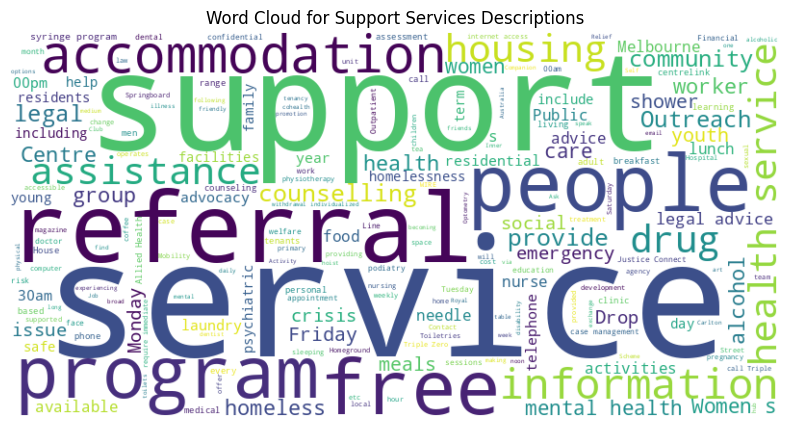

In [ ]:
#Visualisation of a  world cloud to help identify the most common keywords associated with the services
from wordcloud import WordCloud

# Extract the text descriptions from the "what" column
text = " ".join(df["what"].dropna().astype(str).tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Support Services Descriptions")
plt.show()

The word cloud of descriptions of support services provides a visual representation of the most common words or phrases used in the descriptions. This visualization is useful for gaining insights into the key themes or topics related to support services. It helps in identifying the most frequently mentioned aspects, which can be valuable for understanding the focus areas or core features of the services.

As we can see from the word cloud above, some of the common words which would describe the type of support service being offered is accomodation, counselling, housing, homeless, women's, worker and drug which gives us an idea about the type of issues that these support services are targetting.

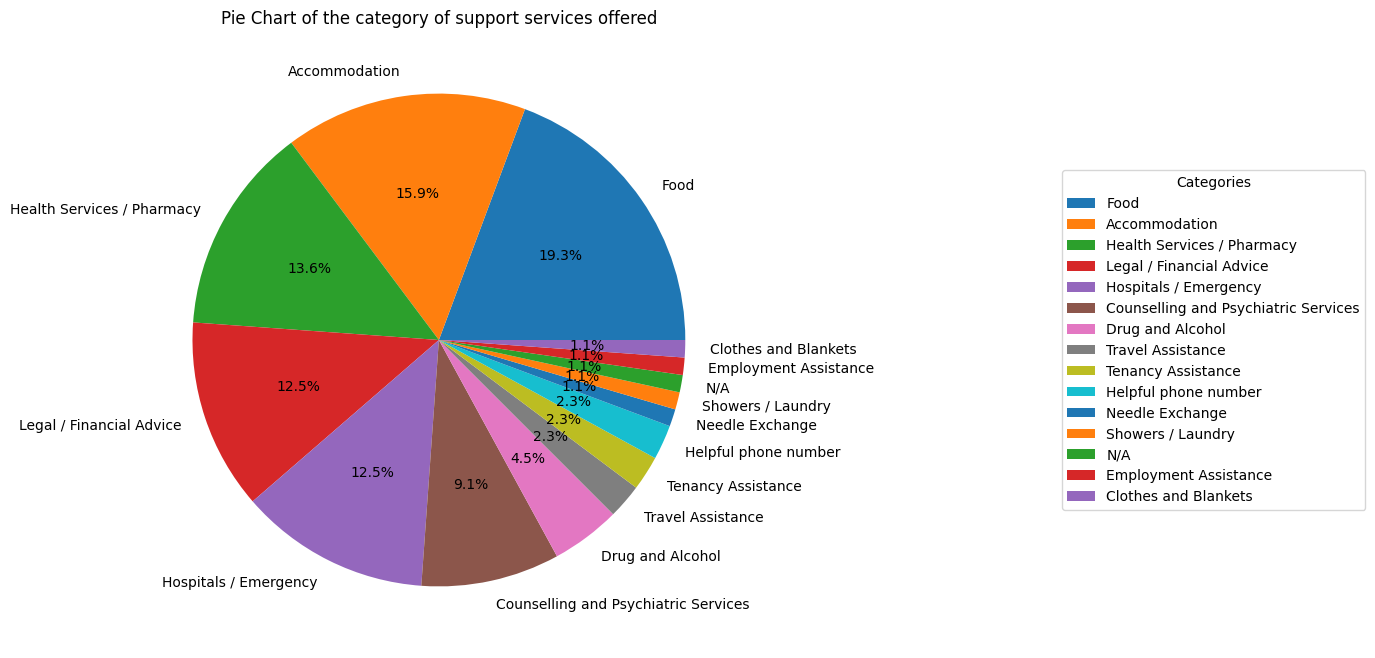

In [ ]:
import matplotlib.pyplot as plt

# Getting the category groups
target_groups = df["category_1"].value_counts()

# Extract the group names and counts
group_names = target_groups.index.to_list()
group_counts = target_groups.to_list()

# Create a pie chart for the different categories
plt.figure(figsize=(10, 8))
plt.pie(group_counts, labels=group_names, autopct="%1.1f%%")

# Creating the legend
plt.legend(title="Categories", loc="center left", bbox_to_anchor=(1.5, 0, 0.5, 1))

plt.title("Pie Chart of the category of support services offered")
plt.show()


The pie chart visualizes the distribution of support services across different categories.It can aid in identifying which categories have higher or lower representation, which can inform resource allocation, policy decisions, and service planning efforts. The chart provides a quick and intuitive overview of the distribution, making it easier to identify patterns and trends in the data.From the pie chart above, we can see that a few of the major categories of support services offered are food with 19.3%, accomodation with 15.9% and health services  with 13.6%

# **Exploring of the bus stops and tram tracks datasets**

This section involved a detailed analysis of the bus and tram datasets to gain insights into the columns and values of the dataset and distribution and density of bus stops and tram tracks across the area of interest. The exploration aimed to understand the accessibility and coverage of public transportation options in the region.

In [ ]:
df_bus_stop.head(5) #overview of the bus stops dataset


,id,timestamp,size,lon,lat,type,coordinates,type,prop_id,addresspt1,...,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,8a7367eeeb000301c668152ba5dba9ff25ad3a1c,2022-11-13T10:04:50.153Z,282,144.968896,-37.818425,Feature,"[144.96889648633675, -37.81842481335676]",Point,573333,29.149053,...,Sign - Public Transport,749,1249454,606816,None,Sign - Public Transport 1 Panel,1249454,0,Sign - Public Transport 1 Panel Bus Stop Type 12,P.16
1,8d32170acd436dc5d240120e04aa0b394dbbe762,2022-11-13T10:04:50.153Z,282,144.958882,-37.817676,Feature,"[144.95888238475013, -37.81767597164006]",Point,0,10.537902,...,Sign - Public Transport,2098,1247042,507646,None,Sign - Public Transport 1 Panel,1247042,20118,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,a28d5d448682f46db10d2e29c83adae14c26f2db,2022-11-13T10:04:50.153Z,281,144.959632,-37.781889,Feature,"[144.95963193312105, -37.78188915501449]",Point,0,25.269643,...,Sign - Public Transport,2143,1252383,108510,None,Sign - Public Transport 1 Panel,1252383,22387,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
3,5ece9979014dc6b130ba352fbf03046d6741aff1,2022-11-13T10:04:50.153Z,281,144.947167,-37.793727,Feature,"[144.94716743007305, -37.793726533289785]",Point,0,44.230506,...,Sign - Public Transport,2627,1249788,100087,None,Sign - Public Transport 1 Panel,1249788,20919,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
4,85ffb2cb3cbbd99440315bab55910949c3572d91,2022-11-13T10:04:50.153Z,282,144.927785,-37.802862,Feature,"[144.92778487963457, -37.80286165064241]",Point,0,67.718553,...,Sign - Public Transport,3306,1235311,103002,None,Sign - Public Transport 1 Panel,1235311,21680,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16


In [ ]:
df_bus_stop.info() #information about the columns and values of the columns in the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 0 to 8
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           309 non-null    object 
 1   timestamp    309 non-null    object 
 2   size         309 non-null    object 
 3   lon          309 non-null    float64
 4   lat          309 non-null    float64
 5   type         309 non-null    object 
 6   coordinates  309 non-null    object 
 7   type         309 non-null    object 
 8   prop_id      309 non-null    object 
 9   addresspt1   309 non-null    float64
 10  addressp_1   309 non-null    object 
 11  asset_clas   309 non-null    object 
 12  asset_type   309 non-null    object 
 13  objectid     309 non-null    object 
 14  str_id       309 non-null    object 
 15  addresspt    309 non-null    object 
 16  asset_subt   0 non-null      object 
 17  model_desc   309 non-null    object 
 18  mcc_id       309 non-null    object 
 19  roadseg_id   30

 The bus stop dataset comprises 309 entries and 21 columns. The dataset contains a mix of numerical and textual data, providing detailed information about each bus stop's location, classification, and attributes.

In [ ]:
df_tram_tracks.head(5) #overview of the tram tracks dataset

,id,timestamp,size,lon,lat,type,coordinates,type,descriptio,name
0,6367ab838d06963b6a3aa4d22b23651502923987,2022-11-13T10:05:52.941Z,649,144.955678,-37.810155,Feature,"[[[[144.955454056839, -37.8097457246493], [144...",MultiPolygon,<center><table><tr><th colspan='2' align='cent...,kml_13
1,fe09603240fd2860951e1468796ca65c9962cbd4,2022-11-13T10:05:52.941Z,722,144.959455,-37.815324,Feature,"[[[[144.958358092682, -37.8156091337363], [144...",MultiPolygon,<center><table><tr><th colspan='2' align='cent...,kml_14
2,53af8dc57bca9d173e8130cf5db164187d80e175,2022-11-13T10:05:52.941Z,2081,144.956783,-37.801184,Feature,"[[[[144.956816503317, -37.8011090399539], [144...",MultiPolygon,<center><table><tr><th colspan='2' align='cent...,kml_19
3,8a1aeb1791890a2de5d5e98dbca5b6c794c3ebee,2022-11-13T10:05:52.941Z,500,144.965494,-37.813569,Feature,"[[[[144.965484540487, -37.8136038043156], [144...",MultiPolygon,<center><table><tr><th colspan='2' align='cent...,kml_21
4,edb805bfa53a27b57bb087bce5d170bd7015a124,2022-11-13T10:05:52.941Z,3438,144.940489,-37.787818,Feature,"[[[[144.940458640488, -37.7877501106288], [144...",MultiPolygon,<center><table><tr><th colspan='2' align='cent...,kml_25


In [ ]:
df_tram_tracks.info() #information about the columns and values of the columns in the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 645 entries, 0 to 44
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           645 non-null    object 
 1   timestamp    645 non-null    object 
 2   size         645 non-null    object 
 3   lon          645 non-null    float64
 4   lat          645 non-null    float64
 5   type         645 non-null    object 
 6   coordinates  645 non-null    object 
 7   type         645 non-null    object 
 8   descriptio   645 non-null    object 
 9   name         645 non-null    object 
dtypes: float64(2), object(8)
memory usage: 55.4+ KB


In [ ]:
#Find the missing values for the bus stops dataset
df_bus_stop.isnull().sum()

id               0
timestamp        0
size             0
lon              0
lat              0
type             0
coordinates      0
type             0
prop_id          0
addresspt1       0
addressp_1       0
asset_clas       0
asset_type       0
objectid         0
str_id           0
addresspt        0
asset_subt     309
model_desc       0
mcc_id           0
roadseg_id       0
descriptio       0
model_no         0
dtype: int64

In [ ]:
#Find the missing values for the tram tracks dataset
df_tram_tracks.isnull().sum()

id             0
timestamp      0
size           0
lon            0
lat            0
type           0
coordinates    0
type           0
descriptio     0
name           0
dtype: int64

Since there are no missing values for both datasets for the longitude and latitude values which would be used in the analysis, there is no further data cleaning to be done

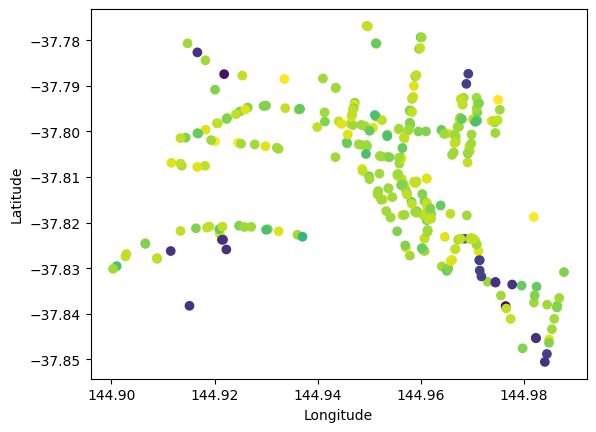

In [ ]:
# Plotting the bus stop locations

import matplotlib.pyplot as plt
plt.scatter(df_bus_stop['lon'], df_bus_stop['lat'], c=df_bus_stop['size'])
plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')

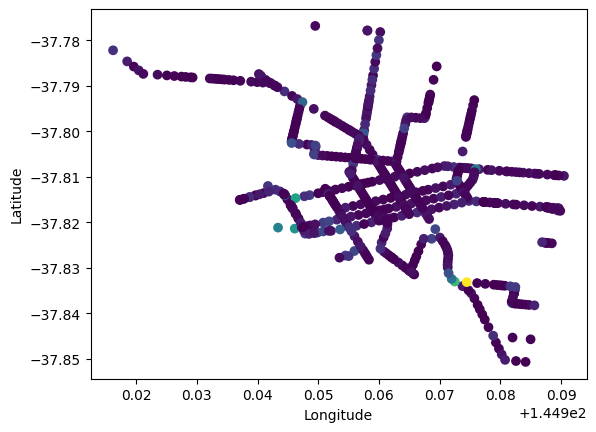

In [ ]:
#Plotting the tram track locations

import matplotlib.pyplot as plt
plt.scatter(df_tram_tracks['lon'], df_tram_tracks['lat'], c=df_tram_tracks['size'])
plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')

By plotting the density of bus stops and tram tracks on a map, the analysis visualized the concentration of stops and tracks in different areas, highlighting areas with high and low accessibility. This information is crucial for assessing the effectiveness of the public transportation network, identifying areas with potential gaps in coverage, and informing decisions related to service improvements or infrastructure development.

In [ ]:
# Add tram stop markers to the map
for index, row in df_tram_tracks.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='green'), popup=row['name']).add_to(map)

# Add bus stop markers to the map
for index, row in df_bus_stop.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='red'), popup=row['descriptio']).add_to(map)

In [ ]:
map


The visualisation of this map integrates all available datasets, including support services, bus stops, and tram tracks, to create a comprehensive map showcasing the spatial distribution of these elements. By combining these datasets into a single map, the analysis provides an overview of the entire transportation and support service landscape in the area of interest.

# **Finding the nearest bus stop or tram stop to the support service**

In this section, we are displaying the nearest bus stop and tram stop to the support services. It allows users to filter support services by name and displays the selected service along with the closest public transportation options. The map would feature markers for support services, clustered for better visualization, and marks the nearest bus stop and tram track for each service. It also draws paths from services to their nearest stops, providing a visual connection for accessibility. The map zooms and pans automatically to focus on selected services, enhancing user experience. Overall, this tool simplifies travel planning and access to support services.

In [ ]:
from math import radians, sin, cos, sqrt, atan2


# Function to calculate distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = radians(lat1), radians(lon1), radians(lat2), radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c

    return distance

# Iterate over each support service and calculate the distance to the nearest bus stop
for index, service_row in df.iterrows():
    nearest_distance = float('inf')  # Initialize with a large value
    for stop_index, stop_row in df_bus_stop.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
    # Update the support service DataFrame with the nearest distance to a bus stop
    df.at[index, 'nearest_bus_stop_distance'] = nearest_distance

# Iterate over each support service and calculate the distance to the nearest tram stop
for index, service_row in df.iterrows():
    nearest_distance = float('inf')  # Initialize with a large value
    for stop_index, stop_row in df_tram_tracks.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
    # Update the support service DataFrame with the nearest distance to a tram
    # stop
    df.at[index, 'nearest_tram_track_distance'] = nearest_distance


This code calculates the distance from each support service location to the nearest bus stop and tram track using the Haversine formula to account for the Earth's curvature. It iterates through each support service location and calculates the distance to each bus stop and tram track, updating the DataFrame with the nearest distances. This information can be used for mapping and analysis, providing insights into the accessibility of support services via public transport.

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a map object
map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Add support service markers to the map
service_marker_cluster = MarkerCluster(name='Support Services').add_to(map)
for index, service_row in df.iterrows():
    folium.Marker([service_row['lat'], service_row['lon']],
                  popup=service_row['name'],
                  icon=folium.Icon(color='blue', icon='info-sign')).add_to(service_marker_cluster)

# Add nearest bus stop markers and paths to the map
bus_stop_marker_cluster = MarkerCluster(name='Bus Stops').add_to(map)
for index, service_row in df.iterrows():
    nearest_distance = float('inf')
    nearest_bus_stop = None
    for stop_index, stop_row in df_bus_stop.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_bus_stop = stop_row
    if nearest_bus_stop is not None:
        folium.Marker([nearest_bus_stop['lat'], nearest_bus_stop['lon']],
                      popup=f"Nearest Bus Stop to {service_row['name']}",
                      icon=folium.Icon(color='green', icon='bus')).add_to(bus_stop_marker_cluster)

        # Draw a path from support service to bus stop
        points = [[service_row['lat'], service_row['lon']],
                  [nearest_bus_stop['lat'], nearest_bus_stop['lon']]]
        folium.PolyLine(locations=points, color='red', weight=2.5, opacity=1).add_to(map)

# Add nearest tram track markers and paths to the map
tram_track_marker_cluster = MarkerCluster(name='Tram Tracks').add_to(map)
for index, service_row in df.iterrows():
    nearest_distance = float('inf')
    nearest_tram_track = None
    for stop_index, stop_row in df_tram_tracks.iterrows():
        distance = haversine_distance(service_row['lat'], service_row['lon'],
                                       stop_row['lat'], stop_row['lon'])
        if distance < nearest_distance:
            nearest_distance = distance
            nearest_tram_track = stop_row
    if nearest_tram_track is not None:
        folium.Marker([nearest_tram_track['lat'], nearest_tram_track['lon']],
                      popup=f"Nearest Tram Track to {service_row['name']}",
                      icon=folium.Icon(color='purple', icon='train')).add_to(tram_track_marker_cluster)

        # Draw a path from support service to tram track
        points = [[service_row['lat'], service_row['lon']],
                  [nearest_tram_track['lat'], nearest_tram_track['lon']]]
        folium.PolyLine(locations=points, color='blue', weight=2.5, opacity=1).add_to(map)

# Add layer control to toggle markers and paths
folium.LayerControl().add_to(map)

# Display the map
map


This map shows where support services are located, like shelters or food banks and all the different types of the support services marked by the blue marker and the specific support service they are offering can be found by hovering on the blue marker. It also shows the nearest bus stops and tram tracks to those services. The map uses different colors for each type of location, like blue for support services, green for bus stops, and red for tram tracks. The path to the bus stop or tram tracks in the closest distance can be seen as well on the map. This helps people see which services are near public transportation, making it easier to access help when needed.

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a map object
map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Get user input for filtering
while True:
    filter_service = input("Enter the name of the support service to filter (or press Enter to show all): ")
    filter_service = filter_service.lower()

    # Check if the user input matches any support service names in the dataframe
    if filter_service == "" or any(filter_service in service_name.lower() for service_name in df['name']):
        break
    else:
        print("No services found for the given input. Please try again.")

# Add support service markers to the map
service_marker_cluster = MarkerCluster(name='Support Services').add_to(map)
filtered_services = False
bounds = []
for index, service_row in df.iterrows():
    if pd.notna(service_row['lat']) and pd.notna(service_row['lon']):
        if filter_service == "" or filter_service in service_row['name'].lower():
            service_marker = folium.Marker([service_row['lat'], service_row['lon']], popup=service_row['name'], icon=folium.Icon(color='blue', icon='info-sign'))
            service_marker.add_to(service_marker_cluster)
            filtered_services = True
            bounds.append([service_row['lat'], service_row['lon']])

            # Add nearest bus stop marker and path to the map
            nearest_distance = float('inf')
            nearest_bus_stop = None
            for stop_index, stop_row in df_bus_stop.iterrows():
                distance = haversine_distance(service_row['lat'], service_row['lon'], stop_row['lat'], stop_row['lon'])
                if distance < nearest_distance:
                    nearest_distance = distance
                    nearest_bus_stop = stop_row
            if nearest_bus_stop is not None:
                bus_stop_marker = folium.Marker([nearest_bus_stop['lat'], nearest_bus_stop['lon']], popup=f"Nearest Bus Stop to {service_row['name']}<br>Distance: {nearest_distance:.2f} km", icon=folium.Icon(color='green', icon='bus'))
                bus_stop_marker.add_to(map)
                bounds.append([nearest_bus_stop['lat'], nearest_bus_stop['lon']])
                # Draw a path from support service to bus stop
                points = [[service_row['lat'], service_row['lon']], [nearest_bus_stop['lat'], nearest_bus_stop['lon']]]
                folium.PolyLine(locations=points, color='red', weight=2.5, opacity=1).add_to(map)

            # Add nearest tram track marker and path to the map
            nearest_distance = float('inf')
            nearest_tram_track = None
            for stop_index, stop_row in df_tram_tracks.iterrows():
                distance = haversine_distance(service_row['lat'], service_row['lon'], stop_row['lat'], stop_row['lon'])
                if distance < nearest_distance:
                    nearest_distance = distance
                    nearest_tram_track = stop_row
            if nearest_tram_track is not None:
                tram_track_marker = folium.Marker([nearest_tram_track['lat'], nearest_tram_track['lon']], popup=f"Nearest Tram Track to {service_row['name']}<br>Distance: {nearest_distance:.2f} km", icon=folium.Icon(color='purple', icon='train'))
                tram_track_marker.add_to(map)
                bounds.append([nearest_tram_track['lat'], nearest_tram_track['lon']])
                # Draw a path from support service to tram track
                points = [[service_row['lat'], service_row['lon']], [nearest_tram_track['lat'], nearest_tram_track['lon']]]
                folium.PolyLine(locations=points, color='blue', weight=2.5, opacity=1).add_to(map)

# Display a message if no services were found for the given filters
if not filtered_services:
    print("No services found for the given filters.")
else:
    # Zoom the map to the bounds of the markers
    map.fit_bounds(bounds)

# Display the map
map

Enter the name of the support service to filter (or press Enter to show all): The Alfred


This map allows users to filter the support services by name, and the map will display markers for the matching services along with their nearest public transportation options. The code calculates the distances between the support services and the bus stops/tram tracks, and draws paths connecting them. The map automatically zooms to the relevant area based on the filtered results, providing a focused view. Users can interact with the map to explore the support services and their public transportation connections.


# **Conclusion**

The completion of the support services use case involved data exploration, cleaning, and visualization tasks. The exploration and cleaning of the support services dataset ensured data integrity and consistency, while the visualizations, including pie charts and word clouds, provided valuable insights into the distribution and types of support services. Exploration of the bus and tram datasets further enhanced our understanding of the public transportation network's distribution and density.

The development of an interactive map was a significant milestone, allowing users to search for support services by name and view their nearest bus stops and tram tracks and a path to it with the number of kms away that specific bus or tram stop is. The integration of pathfinding algorithms and distance calculations provided users with essential information on transportation accessibility, enhancing the user experience. Additionally, the zoom and focus feature improved map usability, providing users with a clear and focused view of selected support services and their surroundings.


**Limitations:**
In the support services dataset, there were a few limitations that affected the analysis and visualization process:
* Lack of Specificity in Categorization: The categorization of support services was not always specific enough leading to broad categories that may not adequately represent the diversity of services available. This limited the insights gained from analyzing the distribution of support services across different categories.
* The bus stops and tram stops were not identified with their actual names that would have been easily understandable for the users

**Next trimester plan:**

Developing a predictive model using machine learning algorithms to identify areas

*   Develop a predictive model using machine learning algorithms to identify areas with support services but inadequate bus or tram accessibility.
*   Use spatial analysis techniques to assess the impact of public transportation infrastructure on the accessibility of support services.
*   Conduct a thorough evaluation of the model's performance using relevant metrics and refine it iteratively to improve prediction accuracy.
*   Consider the implementation of interactive visualizations or dashboards to present the model's insights to stakeholders and decision-makers effectively.


Overall, the completion of the support services use case and the plan for future development demonstrate a commitment to using data-driven insights and innovative solutions to address societal challenges and improve community well-being.